# **Set Working Directory**

In [1]:
%cd 'drive/My Drive/LOCALIZATION/Transfer-Learning-Localization'
%ls

/content/drive/My Drive/LOCALIZATION/Transfer-Learning-Localization
CIMATDATASETS/  models/   __pycache__/  utils.py
main.ipynb      outputs/  README.md


# **Load required data**

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from models import models
import utils

# set the Dataset path: 'CIMATDATASETS/CIMAT-NAO-A' or 'CIMATDATASETS/CIMAT-NAO-B'
path_dataset = 'CIMATDATASETS/CIMAT-NAO-A'

# fixed phat
visual_map_path = path_dataset + '/Dataset-VisualMemory'
test_path = path_dataset + '/Dataset-Tests'
gt_path = path_dataset + '/gt_test_idx.csv'
train_idxs_path = path_dataset + '/train_idx.csv'
aug_path = path_dataset + '/AUG'

# set to True if not map augmentation wasn't previously carried out 
map_augmentation = False 

# create model: 'ResNet50', 'VGG16', 'InceptionV3' or 'Xception'
model_name = 'ResNet50'
use_l2 = True
classes = 187 # 187-CIMAT-NAO A, 95-CIMAT-NAO-B
model, dim = models.pretrainedmodel(classes=classes, name_model=model_name, use_l2=use_l2)
model._name = model_name
#model.summary()

# generate a single time the augmented images
if map_augmentation:
    utils.mapaugmentation(visual_map_path, aug_path, 30)

# load augmented-training set
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        )

batch_size = 10
train_generator = train_datagen.flow_from_directory(
    directory=aug_path,
    target_size=  (dim[0], dim[1]),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

# load test & ground-truth data 
test_imgs, y_test, gt_test_idx, train_idx = utils.loadtestimages(test_path, dim, gt_path, train_idxs_path)


94773248/94765736 [==============================] - 0s 0us/step
Found 5595 images belonging to 187 classes.


258it [01:18,  3.28it/s]


# **Create the model**

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

# load visual map as validation data
val_imgs, y_val = utils.loadvisualmap(visual_map_path, dim)

# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=50, verbose=1, restore_best_weights = True)
checkpoint_filepath = 'outputs/A_ResNet_l2.hdf5' # configure the checkpoint filename
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
		filepath=checkpoint_filepath,
		monitor='val_loss',
		save_best_only=True, 
		#save_weights_only=True,
		verbose=1)
callbacks = [model_checkpoint_callback, early_stopping]

# compile model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])



187it [00:55,  3.34it/s]


# **Train the model**

In [4]:
# train model
BS = 128
EPOCHS = 100

print("[INFO] training network for {} epochs...".format(EPOCHS))
H = model.fit(
	train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data = (val_imgs, y_val),
    batch_size = BS, 
	epochs=EPOCHS,
    callbacks = callbacks,
    verbose=0)

[INFO] training network for 100 epochs...

Epoch 00001: val_loss improved from inf to 5.22969, saving model to outputs/A_ResNet_l2.hdf5

Epoch 00002: val_loss improved from 5.22969 to 5.22810, saving model to outputs/A_ResNet_l2.hdf5

Epoch 00003: val_loss improved from 5.22810 to 5.22489, saving model to outputs/A_ResNet_l2.hdf5

Epoch 00004: val_loss improved from 5.22489 to 5.21870, saving model to outputs/A_ResNet_l2.hdf5

Epoch 00005: val_loss improved from 5.21870 to 5.20944, saving model to outputs/A_ResNet_l2.hdf5

Epoch 00006: val_loss improved from 5.20944 to 5.19655, saving model to outputs/A_ResNet_l2.hdf5

Epoch 00007: val_loss improved from 5.19655 to 5.18099, saving model to outputs/A_ResNet_l2.hdf5

Epoch 00008: val_loss improved from 5.18099 to 5.16375, saving model to outputs/A_ResNet_l2.hdf5

Epoch 00009: val_loss improved from 5.16375 to 5.14431, saving model to outputs/A_ResNet_l2.hdf5

Epoch 00010: val_loss improved from 5.14431 to 5.12253, saving model to outputs

# **Test the model**

In [5]:
model.layers[-2].name, model.layers[-2].get_weights()

('l2_layer', [array([53.02233], dtype=float32)])

In [6]:
model.evaluate(test_imgs, y_test)

9/9 [==============================] - 1s 113ms/step - loss: 1.9857 - accuracy: 0.4457 - top_k_categorical_accuracy: 0.8178


[1.9857033491134644, 0.44573643803596497, 0.817829430103302]

In [7]:
model.save_weights('outputs/final-weights.hdf5')

# **Plot the top-3 retrieved key-images**

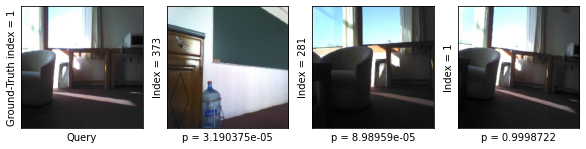

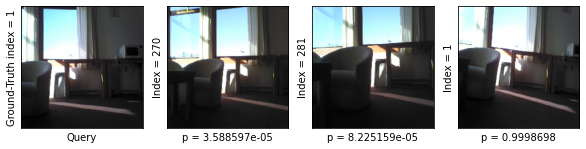

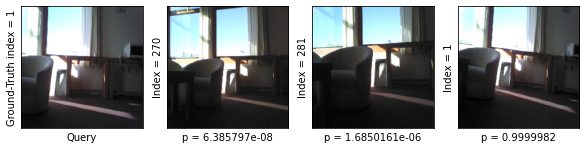

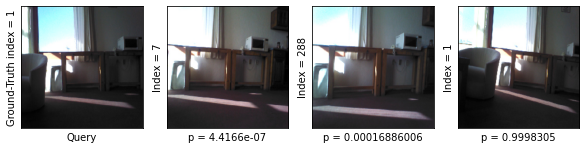

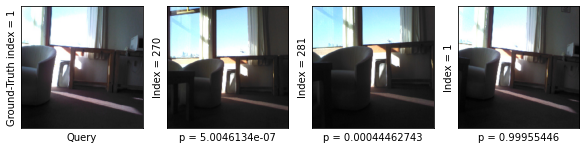

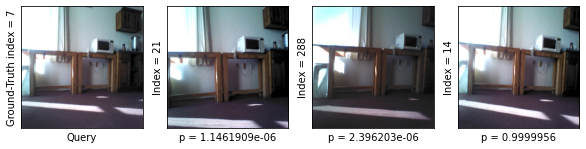

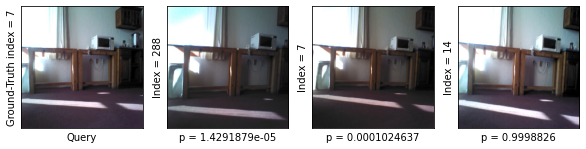

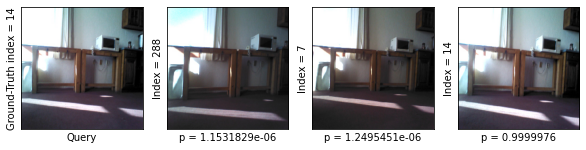

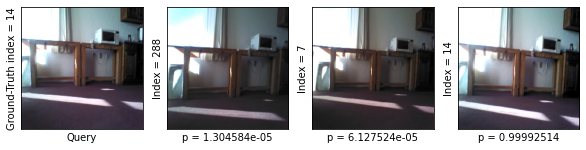

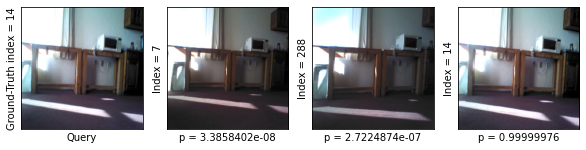

In [9]:
for i, test_img in enumerate(test_imgs[:10]):
    test_img_tensor = np.expand_dims(test_img, 0)
    r = utils.localization(model, test_img_tensor, train_idx)
    utils.plottopk(val_imgs, test_img, r, gt_test_idx[i])

# **Restore the best model's weights**

In [10]:
model2, dim = models.pretrainedmodel(classes, 'ResNet50')

In [11]:
model2.load_weights('outputs/final-weights.hdf5')

In [12]:
model2.layers[-2].name, model2.layers[-2].get_weights()

('l2_layer_1', [array([53.02233], dtype=float32)])